In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [30]:
import nltk
from tqdm.notebook import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline

[nltk_data] Downloading package vader_lexicon to C:\Users\Debjit
[nltk_data]     Mandal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Debjit
[nltk_data]     Mandal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Debjit Mandal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


   rating                                            content  \
0     NaN                     smooth Good And better Quality   
1     NaN  Only thing bad is camera quality. Worst image ...   
2     NaN  It’s a great product for the price . Very flui...   
3     NaN                                      Super quality   
4     NaN  Redmi 12 5G (6GB/128GB)\n\nOverview: Having us...   

                                             variant               name  \
0  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...  Salik Ahamad Khan   
1  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...          Darshan P   
2  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...       Yajveer Arya   
3  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...           Srinivas   
4  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...        Placeholder   

                               date  verified sub_reviews  
0   Reviewed in India on 8 May 2024      True          []  
1  Reviewed in India on 14 May 2024      Tru

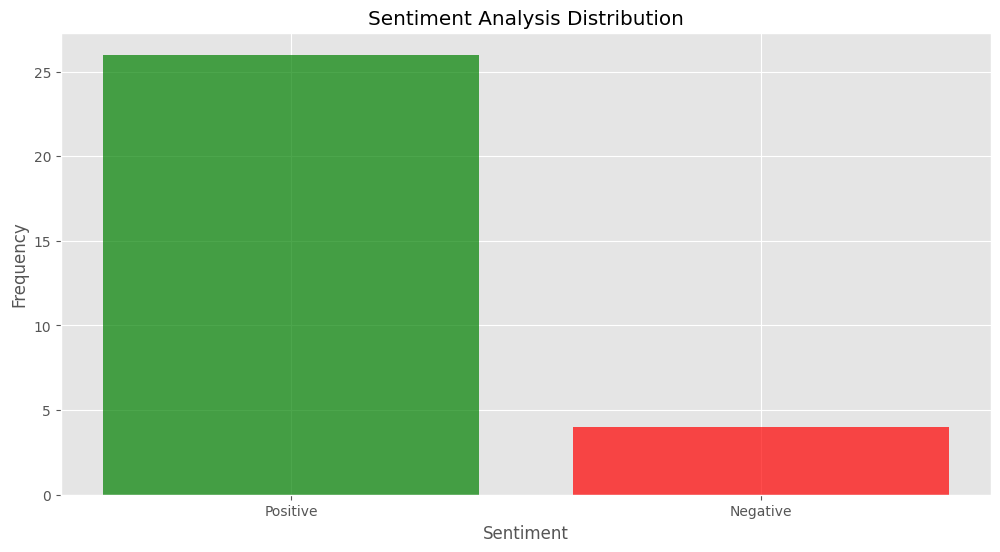

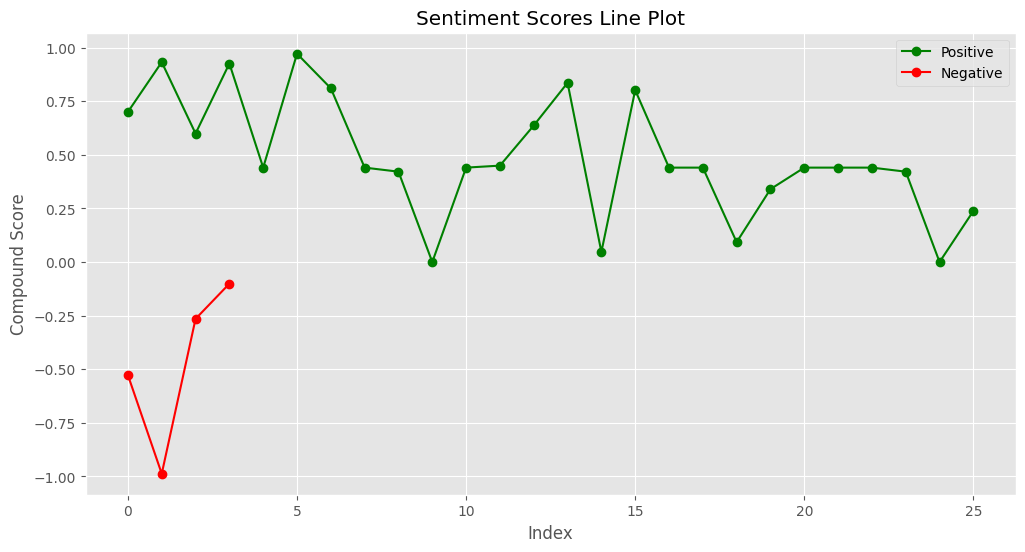

In [31]:
# Download the necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Load the data
df = pd.read_csv("./example_reviews.csv")
sia = SentimentIntensityAnalyzer()

# Check and remove duplicate rows
df = df.drop_duplicates()

# Check for and handle duplicate column labels
df = df.loc[:, ~df.columns.duplicated()]

# Print the DataFrame to ensure it is clean
print(df.head())
print("Column names:", df.columns.tolist())

# Perform sentiment analysis and add the results to the DataFrame
df['compound'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['label'] = df['compound'].apply(lambda x: 'POSITIVE' if x >= 0 else 'NEGATIVE')

# Visualization of the sentiment analysis results using bar chart
positive_scores = df[df['label'] == 'POSITIVE']['compound']
negative_scores = df[df['label'] == 'NEGATIVE']['compound']

# Bar chart for sentiment distribution
plt.figure(figsize=(12, 6))
labels = ['Positive', 'Negative']
values = [len(positive_scores), len(negative_scores)]
colors = ['green', 'red']

plt.bar(labels, values, color=colors, alpha=0.7)
plt.title('Sentiment Analysis Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

# Line plot for sentiment scores
plt.figure(figsize=(12, 6))
plt.plot(positive_scores.values, color='green', label='Positive', linestyle='-', marker='o')
plt.plot(negative_scores.values, color='red', label='Negative', linestyle='-', marker='o')
plt.title('Sentiment Scores Line Plot')
plt.xlabel('Index')
plt.ylabel('Compound Score')
plt.legend()
plt.show()


In [32]:
df['content'].values[0]

'smooth Good And better Quality'

In [33]:
test = df['content'][0]
print (test)
tokens = nltk.word_tokenize(test)
nltk.pos_tag(tokens)
sia.polarity_scores(test)

smooth Good And better Quality


{'neg': 0.0, 'neu': 0.341, 'pos': 0.659, 'compound': 0.7003}

In [34]:
pipe = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


C:\Users\Debjit Mandal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [35]:
pipe(test)

[{'label': 'POSITIVE', 'score': 0.999860405921936}]

In [36]:
# Function to analyze sentiment using NLTK's SentimentIntensityAnalyzer
def analyze_sentiment_nltk(text):
    scores = sia.polarity_scores(text)
    return scores

In [37]:
# Function to analyze sentiment using Hugging Face pipeline
def analyze_sentiment_transformer(text):
    test = text[:100]
    result = pipe(test)[0]
    return result

In [38]:
# Apply sentiment analysis to all reviews
nltk_sentiments = df['content'].apply(analyze_sentiment_nltk)
transformer_sentiments = df['content'].apply(analyze_sentiment_transformer)

In [39]:
# Convert the results to separate DataFrames
nltk_df = pd.DataFrame(nltk_sentiments.tolist())
transformer_df = pd.DataFrame(transformer_sentiments.tolist())

In [40]:
# Combine the results with the original DataFrame
df = pd.concat([df, nltk_df, transformer_df], axis=1)
# Save the DataFrame to a new CSV file
df.to_csv('updated_reviews.csv', index=False)

In [41]:
# Display the DataFrame with sentiment scores
print(df.head())


   rating                                            content  \
0     NaN                     smooth Good And better Quality   
1     NaN  Only thing bad is camera quality. Worst image ...   
2     NaN  It’s a great product for the price . Very flui...   
3     NaN                                      Super quality   
4     NaN  Redmi 12 5G (6GB/128GB)\n\nOverview: Having us...   

                                             variant               name  \
0  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...  Salik Ahamad Khan   
1  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...          Darshan P   
2  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...       Yajveer Arya   
3  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...           Srinivas   
4  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...        Placeholder   

                               date  verified sub_reviews  compound     label  \
0   Reviewed in India on 8 May 2024      True          []    0.7003  POSITIVE   
1 